# **Social Network Analysis. Individual Assignment**


---


## Author: Alfonso Ferrándiz Hervella
## Tutor: Álvaro Romero Miralles
## Program: Master in Business Analytics and Big Data - Part-Time
## Date: April 2023



---



#0. Uploading the needed libraries

In [1]:
# Installing the libraries

!pip install python-igraph
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.3 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=c4e7c50558618db4d5e4611b1a5a984c02d4fc63d48727cde103a83009e8ed47
  Stored in directory: /root/.cache/pip/wheels/dc/07/ac/bff79052fd6222d1239b228cd24a47222f227c2350f9c4df01
Successfully built python-igraph
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgif-dev is already the newest version (5.1.9-1).
libgif-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libbl

In [2]:
# Importing the libraries

from igraph import *
import cairo
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

#1. Loading the data
In this section, the goal is loading the datasets given, building the graph and analyzing basics metrics. Include the edge or node attributes you consider.

In [3]:
# We start loading the data from our Github repository
actors_df = pd.read_csv('https://raw.githubusercontent.com/fonsofhervella/sna_individual/main/imdb_actors_key_sol.csv', sep=';')
collaborations_df = pd.read_csv('https://raw.githubusercontent.com/fonsofhervella/sna_individual/main/imdb_actor_edges_sol.csv',sep=';')


We are going to take a quick look at the loaded data


In [4]:
actors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17577 entries, 0 to 17576
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            17577 non-null  object
 1   ActorName     17577 non-null  object
 2   movies_95_04  17577 non-null  int64 
 3   main_genre    17509 non-null  object
 4   genres        17577 non-null  object
dtypes: int64(1), object(4)
memory usage: 686.7+ KB


In [5]:
actors_df.head()

,id,ActorName,movies_95_04,main_genre,genres
0,n15629,"Rudder, Michael (I)",12,Thriller,"Action:1,Comedy:1,Drama:1,Fantasy:1,Horror:1,N..."
1,n5026,"Morgan, Debbi",16,Drama,"Comedy:2,Documentary:1,Drama:6,Horror:2,NULL:3..."
2,n11252,"Bellows, Gil",33,Drama,"Comedy:6,Documentary:1,Drama:7,Family:1,Fantas..."
3,n5150,"Dray, Albert",20,Comedy,"Comedy:6,Crime:1,Documentary:1,Drama:4,NULL:5,..."
4,n4057,"Daly, Shane (I)",18,Drama,"Comedy:2,Crime:1,Drama:7,Horror:1,Music:1,Musi..."


In [6]:
collaborations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287074 entries, 0 to 287073
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   from    287074 non-null  object
 1   to      287074 non-null  object
 2   weight  287074 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.6+ MB


In [7]:
collaborations_df.head()

,from,to,weight
0,n17776,n17778,6
1,n5578,n9770,3
2,n5578,n929,2
3,n5578,n9982,2
4,n1835,n6278,2


In [8]:
# In the preliminary analysis, we are going to check if the sum of weights equal the number of movies
total_weight = collaborations_df["weight"].sum()
print("The total weight is:", total_weight)

total_movies = actors_df["movies_95_04"].sum()
print("The total movies are:", total_movies)

The total weight is: 941949
The total movies are: 361124


Based on the preliminary analysis, we can see that genre is the only column with nulls. The column movies_95_04 in the actors_df, includes the number of movies that in which the actor has participated during the period.
Also, and this is really important, **we have much more weights than movies**. Weights, due to that fact, are not representing number of movies where actors have worked together but other, unknown at this point, variable, as, i.e., time shared in screen

In [9]:
# Preparing the collaborations_df to use it as our main df for creating the graph
collaborations_df = collaborations_df.merge(actors_df[['id', 'ActorName']], left_on='from', right_on='id', how='left')
collaborations_df = collaborations_df.merge(actors_df[['id', 'ActorName']], left_on='to', right_on='id', how='left')

In [10]:
# Checking that everything has worked fine
collaborations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287074 entries, 0 to 287073
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   from         287074 non-null  object
 1   to           287074 non-null  object
 2   weight       287074 non-null  int64 
 3   id_x         287074 non-null  object
 4   ActorName_x  287074 non-null  object
 5   id_y         287074 non-null  object
 6   ActorName_y  287074 non-null  object
dtypes: int64(1), object(6)
memory usage: 17.5+ MB


In [11]:
# Getting our df ready
collaborations_df = collaborations_df.drop(columns=['id_x', 'id_y'])
collaborations_df.rename(columns={'ActorName_x': 'from_name', 'ActorName_y': 'to_name'}, inplace=True)

In [12]:
# Checking results
collaborations_df.head()

,from,to,weight,from_name,to_name
0,n17776,n17778,6,"Wood, T.J.","Black, Rick (II)"
1,n5578,n9770,3,"Gale, Vincent (I)","Gray, G. Michael"
2,n5578,n929,2,"Gale, Vincent (I)","Holden, Mark (IV)"
3,n5578,n9982,2,"Gale, Vincent (I)","Gray-Stanford, Jason"
4,n1835,n6278,2,"Moore, Ashley (II)","Star, Judy"


In [13]:
# We are going to create a list with unique actors names
actor_names = list(set(list(collaborations_df['from_name']) + list(collaborations_df['to_name'])))

In [14]:
# To be sure that everything is working fine, we will check how many different names do we have in the list

l1 = []
count = 0

for item in actor_names:
    if item not in l1:
        count += 1
        l1.append(item)
 
print("The number of unique items in actor names list is:", count)

The number of unique items in actor names list is: 17577


In [15]:
# For creating the graph, first we define it. Then we add nodes from our actor_names list. Then, we have added an iterrows to 
# stablish the edges. Despite iterrows is a slow way, I was having issues to get the proper edges without it (each run of the
# code they were changing). Finally, we make the graph undirected.

g = Graph()

# Adding vertices
g.add_vertices(actor_names)

# Adding edges
for i, row in collaborations_df.iterrows():
    from_name = row['from_name']
    to_name = row['to_name']
    weight = row['weight']
    g.add_edge(from_name, to_name, weight=weight)

g.to_undirected()



In [16]:
# We check graph properties
g.summary()

'IGRAPH UNW- 17577 287074 -- \n+ attr: name (v), weight (e)'

We graph an undirected, named and weighted graph, composed by 17,577 nodes and 287,074 edges

In [17]:
# We check graph object
g

In [18]:
# We create a vertex dataframe and we named it g_df. This df will be used for showing the degrees in the next exercise
g_df= g.get_vertex_dataframe()

In [19]:
# As the adjancecy matrix is too big we stored it as a pandas DataFrame and we save it
# in a csv file. When running this notebook in Google Colab, the csv file can be downloaded
# at the left side. Uncomment the next lines if you want to download the adjacency matrix. It
# will take a while

# adj_matrix = pd.DataFrame(g.get_adjacency().data, columns=g.vs["label"])

# adj_matrix.to_csv("adj_matrix.csv", index=False)

#2. Degree 
Analyse the degree distribution. Compute the total degree distribution.

In [20]:
# First, we calculate the minimum and maximum degree of the vertices in the graph
min_degree = min(g.degree())
max_degree = max(g.degree())

print("The Minimum degree is:", min_degree)
print("The Maximum degree is:", max_degree)

The Minimum degree is: 1
The Maximum degree is: 784


In [21]:
# Method degree does not give us the weighted degree. If we want to find the weighted degree
# we should use strenght
min_weighted_degree = min(g.strength(weights="weight"))
max_weighted_degree = max(g.strength(weights="weight"))

print("The Minimum weighted degree is:", min_weighted_degree)
print("The Maximum weighted degree is:", max_weighted_degree)

The Minimum weighted degree is: 2.0
The Maximum weighted degree is: 5435.0


In [22]:
# Calculate the average degree of the graph
avg_degree = sum(g.degree()) / len(g.degree())

# Print the result
print("The Average degree is:", avg_degree)

The Average degree is: 32.6647323206463


Average degree is an important measure in Undirected Graphs, as it is related to graph density.

In [23]:
# Calculate the average weighted degree of the graph
avg_weighted_degree = sum(g.strength(weights="weight")) / len(g.strength(weights="weight"))

# Print the result
print("The Average weighted degree is:", avg_weighted_degree)

The Average weighted degree is: 107.17972350230414


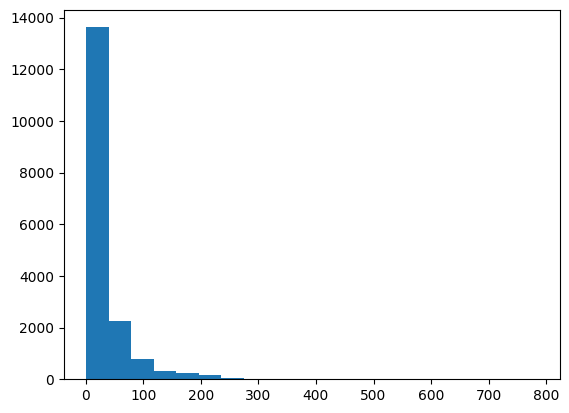

In [24]:
# We will plot a histogram for checking the degree distribution

bins = 20
plt.hist(g.degree(), bins)
plt.show()

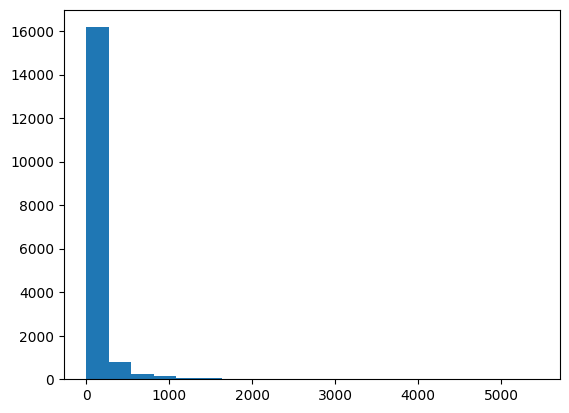

In [25]:
# Now, we will plot a histogram but for the weighted degrees
bins = 20
plt.hist(g.strength(weights="weight"), bins)
plt.show()

In [26]:
# We insert the degrees in our previously built dataframe,
g_df["degree"] = g.degree()
g_df["weighted_degree"] = g.strength(weights="weight")

# With that, we extract the actors with highest degree and highest weighted degree
highest_degree = g_df['degree'].max()  
highest_degree_name = g_df.loc[g_df['degree'] == highest_degree, 'name'].values[0]  
print(f"The person with the highest degree is {highest_degree_name}")

highest_weighted_degree = g_df['weighted_degree'].max()  
highest_weighted_degree_name = g_df.loc[g_df['weighted_degree'] == highest_degree, 'name'].values[0]  
print(f"The person with the highest weighted degree is {highest_weighted_degree_name}")

The person with the highest degree is Davis, Mark (V)
The person with the highest weighted degree is Seldano, Jose


In [27]:
g_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17577 entries, 0 to 17576
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             17577 non-null  object 
 1   degree           17577 non-null  int64  
 2   weighted_degree  17577 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 549.3+ KB


#3.Network Diameter and Average Path Length

You have functions in igraph to calculate the diameter and the average path length. Think if you should consider the weights, the directions, etc.

In [28]:
# As we saw in class, the graph obtained has different clusters or components unconnected between them. Igraph provides us with the components method for that objective.
components = g.components()
print(f"Number of components existing in our graph: {len(components)}")

# Now, we will print each component and how many nodes does it have
for i, component in enumerate(components):
    num_nodes = len(component)
    print(f"Component {i}: Has {num_nodes} nodes")

Number of components existing in our graph: 19
Component 0: Has 17455 nodes
Component 1: Has 22 nodes
Component 2: Has 23 nodes
Component 3: Has 33 nodes
Component 4: Has 2 nodes
Component 5: Has 3 nodes
Component 6: Has 4 nodes
Component 7: Has 2 nodes
Component 8: Has 11 nodes
Component 9: Has 3 nodes
Component 10: Has 2 nodes
Component 11: Has 2 nodes
Component 12: Has 2 nodes
Component 13: Has 2 nodes
Component 14: Has 2 nodes
Component 15: Has 2 nodes
Component 16: Has 3 nodes
Component 17: Has 2 nodes
Component 18: Has 2 nodes


As can be seen, from our 19 components, one represents 99,3% of the total nodes. Now we have 2 options: analyzing just this big component, assuming that it will be a good representation of the total network or analyzing each component separately.

First, we will compute diameter and average path length for each component

In [29]:
# We calculate the diameter of each component, iterating among them
for i, component in enumerate(components):
    subgraph = g.subgraph(component)
    diameter = subgraph.diameter(directed=False)
    print(f"Diameter of component {i}: {diameter}")

Diameter of component 0: 16
Diameter of component 1: 8
Diameter of component 2: 6
Diameter of component 3: 8
Diameter of component 4: 1
Diameter of component 5: 1
Diameter of component 6: 1
Diameter of component 7: 1
Diameter of component 8: 4
Diameter of component 9: 2
Diameter of component 10: 1
Diameter of component 11: 1
Diameter of component 12: 1
Diameter of component 13: 1
Diameter of component 14: 1
Diameter of component 15: 1
Diameter of component 16: 2
Diameter of component 17: 1
Diameter of component 18: 1


In [30]:
# We calculate the average path length of each component, iterating among them
for i, component in enumerate(components):
    subgraph = g.subgraph(component)
    avg_path_length = subgraph.average_path_length(directed=False)
    print(f"Average path length of component {i}: {avg_path_length}")

Average path length of component 0: 4.890557890566182
Average path length of component 1: 3.329004329004329
Average path length of component 2: 3.225296442687747
Average path length of component 3: 3.3011363636363638
Average path length of component 4: 1.0
Average path length of component 5: 1.0
Average path length of component 6: 1.0
Average path length of component 7: 1.0
Average path length of component 8: 1.9090909090909092
Average path length of component 9: 1.3333333333333333
Average path length of component 10: 1.0
Average path length of component 11: 1.0
Average path length of component 12: 1.0
Average path length of component 13: 1.0
Average path length of component 14: 1.0
Average path length of component 15: 1.0
Average path length of component 16: 1.3333333333333333
Average path length of component 17: 1.0
Average path length of component 18: 1.0


10 out of 19 components are just integrated by 2 actors. The information provided in the previous analysis is not being useful for them, as both metrics are getting 1 as a result. For next analysis, we will go for the largest one due to the next reasons:


1.   We believe that in this specific situation, the big component provides insights into the overall structure of the network, the key actors, and the patterns of collaboration among them.
2.    The smaller components in collaboration networks represent isolated groups of actors that are not directly connected to the main structure of the network. 

For that reasons, I have considered that due to the small size of the components, calculating the centrality or distance measures for all the nodes and then applying some normalizing measures can bias how almost the complete network is working



In [31]:
# With this snippet of code we are extracting the biggest component (0) to calculate the next metrics directly upon it
component_0 = [i for i, c in enumerate(components.membership) if c == 0]
subgraph_bc = g.subgraph(component_0)
print(subgraph_bc.summary())

IGRAPH UNW- 17455 286911 -- 
+ attr: name (v), weight (e)


In [32]:
# We calculate again the diameter of the biggest component, to check if the previous snippet of code is working
diameter = subgraph_bc.diameter(directed= False)

print(f"The diameter of the big component, which for us is reprensentative of the whole network, is: {diameter}")

The diameter of the big component, which for us is reprensentative of the whole network, is: 16


In [33]:
# We calculate again the average path length of the biggest component, to double check if the previous snippet of code is working
avg_path_length_bc = subgraph_bc.average_path_length(directed=False)

print(f"The Average path length of the big component, which for us is reprensentative of the whole network, is: {avg_path_length_bc}")

The Average path length of the big component, which for us is reprensentative of the whole network, is: 4.890557890566182


In [34]:
# Now, we will calculate the weighted diameter of the biggest component
weighted_diameter = subgraph_bc.diameter(directed=False, weights='weight')
print(f"The Weighted Diameter of the big component, representative of the whole network: {weighted_diameter}")

The Weighted Diameter of the big component, representative of the whole network: 39.0


In [35]:
# Now, we will calculate the weighted average path lenght of the biggest component
weighted_avg_path_length = subgraph_bc.average_path_length(directed=False, weights='weight')
print(f"The Weighted Average path length of the big component, representative of the whole network: {weighted_avg_path_length}")

The Weighted Average path length of the big component, representative of the whole network: 10.260319096491864


In [36]:
# We create a vertex dataframe for the big component and we named it bcg_df
bcg_df= subgraph_bc.get_vertex_dataframe()
bcg_df.head()

,name
vertex ID,
0,"Bouvet, Jean-Christophe"
1,"Castel, France"
2,"Vallance, Louise"
3,"Fernhout, Roeland"
4,"Hayes, Tanner"


In [37]:
# We check the info to be sure that everything has worked fine
bcg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17455 entries, 0 to 17454
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    17455 non-null  object
dtypes: object(1)
memory usage: 272.7+ KB


# 4. Node importance: Centrality measures

(Optional but recommended): Obtain the distribution of the number of movies made by an actor and the number of genres in which an actor starred in. It may be useful to analyze and discuss the results to be obtained in the following exercises.

In [38]:
# We will start creating a copy of our bcg_df. That's because we want to analyze just the big component (despite the
# other ones are small) and we don't want to mess our bcg_df, which will be used later for plotting centrality metrics
bcg_df_copy = bcg_df.copy()

In [39]:
# We are going to add the columns with information of the actors
bcg_df_copy = bcg_df_copy.merge(actors_df[['ActorName','movies_95_04', 'main_genre', 'genres']], 
                      how='left', 
                      left_on='name', 
                      right_on='ActorName')

# Drop the redundant ActorName column
bcg_df_copy = bcg_df_copy.drop(columns=['ActorName'])

In [40]:
# We have to extract all the information that is stored in the 'genres' column. For that we are going to start by creating a list of unique genres
unique_genres = set()
for row in bcg_df_copy['genres']:
    genres = row.split(',')
    for genre in genres:
        unique_genres.add(genre.split(':')[0])
unique_genres = list(unique_genres)

# Once we have the list, we can add the list of all the genres that are presented in the df as new columns
for genre in unique_genres:
     bcg_df_copy[genre] = 0

# Now we fill the values of each genre with the quantity that was already present in the genres column for each actor
for index, row in  bcg_df_copy.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        name, value = genre.split(':')
        bcg_df_copy.loc[index, name] = int(value)

In [41]:
# We can drop column genres as we have extract the information in different columns
bcg_df_copy.drop('genres', axis=1, inplace=True)

In [42]:
# We check that everything has worked as expected
bcg_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17455 entries, 0 to 17454
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          17455 non-null  object
 1   movies_95_04  17455 non-null  int64 
 2   main_genre    17387 non-null  object
 3   Adult         17455 non-null  int64 
 4   Family        17455 non-null  int64 
 5   Animation     17455 non-null  int64 
 6   Drama         17455 non-null  int64 
 7   Mystery       17455 non-null  int64 
 8   Short         17455 non-null  int64 
 9   Adventure     17455 non-null  int64 
 10  Action        17455 non-null  int64 
 11  Horror        17455 non-null  int64 
 12  Romance       17455 non-null  int64 
 13  Western       17455 non-null  int64 
 14  NULL          17455 non-null  int64 
 15  Comedy        17455 non-null  int64 
 16  Sci-Fi        17455 non-null  int64 
 17  Fantasy       17455 non-null  int64 
 18  Music         17455 non-null  int64 
 19  War 

In [43]:
# We get a list with how many movies have each genre column, to check importance
genre_sums =  bcg_df_copy.iloc[:, 3:].sum().tolist()
total_sum = sum(genre_sums)
print (f"The total number of movies based on genres is: {total_sum}")
print(genre_sums)

The total number of movies based on genres is: 359588
[55149, 8577, 4687, 56818, 3923, 14281, 3369, 11744, 4530, 19071, 1046, 61811, 34150, 8464, 6004, 8142, 2957, 21099, 19839, 12455, 1472]


In [44]:
# We are going to get the sum of movies from the movies column, to check if a movie can be appearing in more than one genre
sum_movies =  bcg_df_copy["movies_95_04"].sum()
print (f"The total number of movies in the big component is: {sum_movies}")

The total number of movies in the big component is: 359588


As we can see, there are 359,588 movies if we sum the movies_95_04 column, and 359,588 movies in the genres columns, so each movie will be assigned just at one genre.

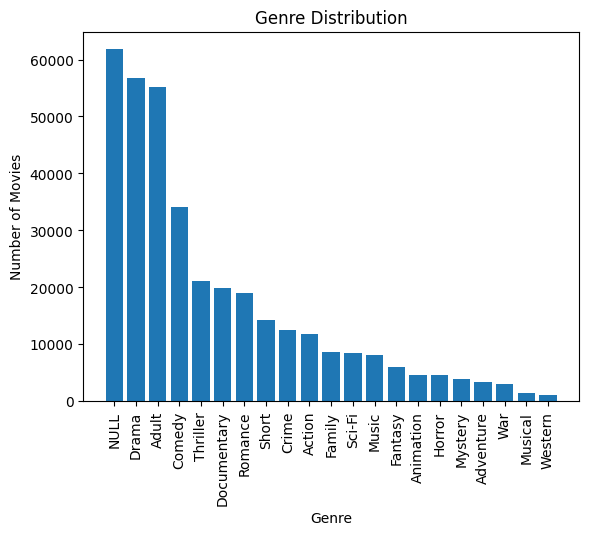

In [45]:
# As previous information was quite difficult to read, we are going to plot a histogram: getting the genre names, creating a dict with genre names and genre sums, ordering it and plotting
genre_names = bcg_df_copy.columns[3:].tolist()

genre_dict = dict(zip(genre_names, genre_sums))
sorted_genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse=True))


plt.bar(range(len(sorted_genre_dict)), list(sorted_genre_dict.values()), align='center')
plt.xticks(range(len(sorted_genre_dict)), list(sorted_genre_dict.keys()), rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Genre Distribution')
plt.show()

As we can see in the previous graph, unluckily we have plenty of null values. The main genre is Drama, followed really closed by Adult and then by comedy. In a more smaller amount, we find Thriller and Documentary in the 4th and 5th place (without considering Null)

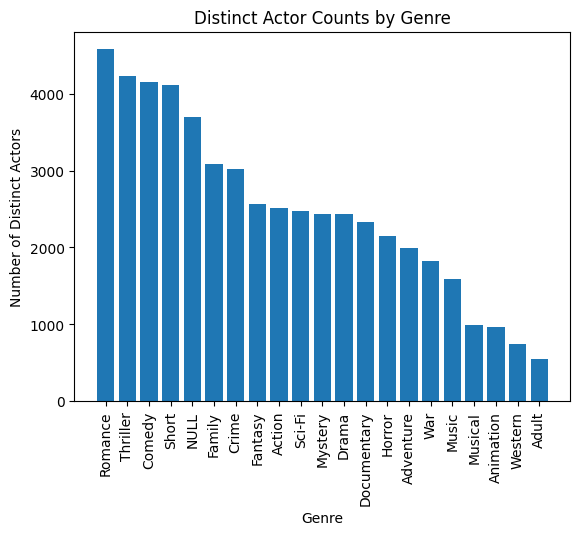

In [46]:
# Now, we will plot a graph with the number of actors in each main genre. First, we count distinct values in genres, then number of actors in each genre and then we plot the graph

def count_distinct(bcg_df_copy, col):
    genre_names = bcg_df_copy.columns[3:].tolist()
    counts = []
    for genre in genre_names:
        counts.append(bcg_df_copy[bcg_df_copy[genre]==1][col].nunique())
    return dict(zip(genre_names, counts))

actor_counts = count_distinct(bcg_df_copy, "name")

# Here we order the data
sorted_actor_counts = dict(sorted(actor_counts.items(), key=lambda item: item[1], reverse=True))

plt.bar(range(len(sorted_actor_counts)), list(sorted_actor_counts.values()), align='center')
plt.xticks(range(len(sorted_actor_counts)), list(sorted_actor_counts.keys()), rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Distinct Actors')
plt.title('Distinct Actor Counts by Genre')
plt.show()

This is a really interesting graph, especially when we contrast it with the number of films. Adult is the second genre with the highest number of movies, but with the lowest number of actors, which seems to explain the high number of movies in which each actor in the adult genre has participated.  In addition, the genres with the highest number of actors such as Romance, Thriller, Short or Family are not among the Top 3 genres with the highest number of movies produced. This seems to indicate that each of these films requires a larger number of actors than, for example, adult film.


In [47]:
# Next, we are creating a new column to get in how many different genres each actor has act. The objective is 
# to check if an actor is versatile or specialized in a genre

bcg_df_copy['num_different_genres'] = (bcg_df_copy.iloc[:, 3:] != 0).sum(axis=1)

# I also rename 'name' column because was causing problems in the next merge
bcg_df_copy = bcg_df_copy.rename(columns={"name": "ActorName"})

bcg_df_copy

,ActorName,movies_95_04,main_genre,Adult,Family,Animation,Drama,Mystery,Short,Adventure,...,Comedy,Sci-Fi,Fantasy,Music,War,Thriller,Documentary,Crime,Musical,num_different_genres
0,"Bouvet, Jean-Christophe",44,Comedy,0,0,0,5,0,8,0,...,15,0,1,0,0,1,0,0,0,7
1,"Castel, France",19,Drama,0,0,0,7,0,0,0,...,1,0,0,0,1,1,0,1,0,7
2,"Vallance, Louise",21,Thriller,0,2,3,1,0,0,1,...,1,1,0,0,0,4,0,0,0,10
3,"Fernhout, Roeland",14,Drama,0,0,0,6,1,0,0,...,0,0,1,0,0,3,0,0,0,6
4,"Hayes, Tanner",15,Adult,11,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17450,"Vitali, Élisabeth",25,Drama,0,0,0,6,0,3,0,...,3,0,0,0,0,0,0,0,0,5
17451,"Tabatabai, Jasmin",24,Drama,0,2,0,6,0,3,0,...,3,0,0,0,0,1,0,2,0,8
17452,"McAlister, Scarlett",16,Drama,0,0,0,4,1,0,0,...,1,1,1,0,0,1,0,0,0,9
17453,"Curry, Stephen",19,Comedy,0,0,0,3,0,1,0,...,9,0,0,1,1,0,1,0,0,8


In [48]:
# First, we calculate the mean of the number of different genres an actor has took part in, which will be useful for further analysis
average_num_genres = bcg_df_copy['num_different_genres'].mean()
print("The Average number of genres an actor has took part in is:", average_num_genres)


The Average number of genres an actor has took part in is: 6.548037811515325


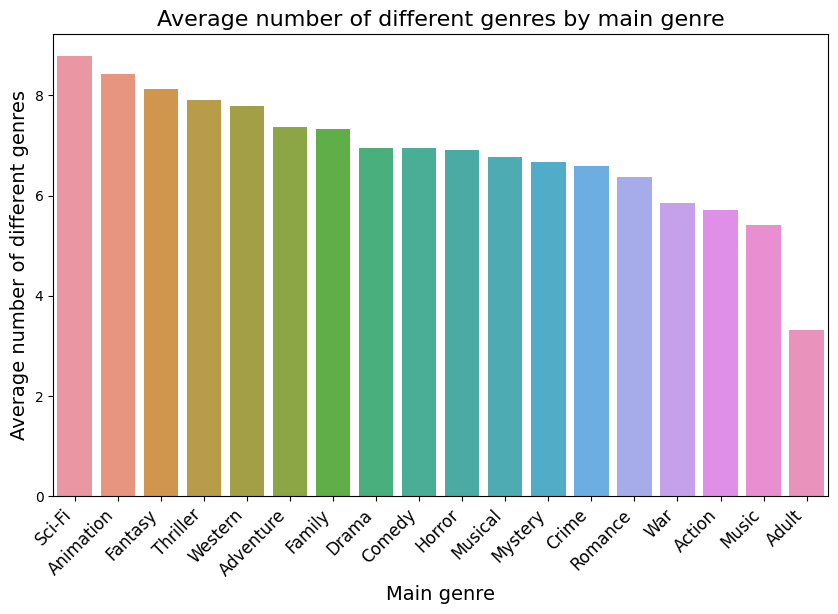

In [49]:

# We plot a graph showing, for each genre, the average number of different genres where they actors have participated

# Group the DataFrame by main genre and calculate the mean of the num_different_genres column for each group
grouped = bcg_df_copy.groupby(['main_genre'])['num_different_genres'].mean().reset_index()

# Sort the grouped DataFrame by the average number of different genres in descending order
grouped = grouped.sort_values(by='num_different_genres', ascending=False)

# In this case, we will create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='main_genre', y='num_different_genres', data=grouped)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Average number of different genres by main genre', fontsize=16)
plt.xlabel('Main genre', fontsize=14)
plt.ylabel('Average number of different genres', fontsize=14)


plt.show()

The average number of different genres an actor has took part in is 6.5. As we can see in the previous graph, actors in Sci-Fi, Animation, Fantasy and thriller are a bit more versatile, in average. On the other hand, actors in the adult genre are much less likely to be involved in other genres.

In [50]:
# We add the columns movies_95_04, main genre and num of different genres to our bcg_df (the one with the vertex for our big component)
bcg_df = bcg_df.merge(bcg_df_copy[['ActorName','movies_95_04', 'main_genre', 'num_different_genres']], 
                      how='left', 
                      left_on='name', 
                      right_on='ActorName')

# As it is no longer needed, we drop the ActorName column
bcg_df=bcg_df.drop(columns=['ActorName'])


In [51]:
g_df = g_df.rename(columns={"name":"ActorName"})

bcg_df = bcg_df.merge(g_df[['ActorName', 'degree', 'weighted_degree']], 
                      how='left', 
                      left_on='name', 
                      right_on='ActorName')

# As it is no longer needed, we drop the ActorName column
bcg_df=bcg_df.drop(columns=['ActorName'])

In [52]:
# checking everything has worked
bcg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17455 entries, 0 to 17454
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  17455 non-null  object 
 1   movies_95_04          17455 non-null  int64  
 2   main_genre            17387 non-null  object 
 3   num_different_genres  17455 non-null  int64  
 4   degree                17455 non-null  int64  
 5   weighted_degree       17455 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 954.6+ KB


Obtain three vectors with the degree, betweeness and closeness for each vertex of the actors' graph.

In [53]:
# The next snippet of code has been developed to calculate degree centrality, betweenness centrality and closeness. We have created
# a dictionary mapping actors name (which are acting as IDs) and the centrality metrics. After that we add them to the bcg_df (which we
# calculated previously). We have used the dictionary to avoid messing up data (mixing vertices_ids and centrality metrics and not
# getting the real picture)

# Calculate centrality measures
betweenness_centrality = subgraph_bc.betweenness(directed=False)
closeness_centrality = subgraph_bc.closeness()

# Create dictionary mapping actor names to centrality measures
bc_dict = OrderedDict(zip(subgraph_bc.vs["name"], betweenness_centrality))
cc_dict = OrderedDict(zip(subgraph_bc.vs["name"], closeness_centrality))

# Add calculated metrics to bcg_df
bcg_df["betweenness_centrality"] = bcg_df["name"].map(bc_dict)
bcg_df["closeness_centrality"] = bcg_df["name"].map(cc_dict)

In [54]:
bcg_df.head()

,name,movies_95_04,main_genre,num_different_genres,degree,weighted_degree,betweenness_centrality,closeness_centrality
0,"Bouvet, Jean-Christophe",44,Comedy,7,34,78.0,63420.753086,0.222183
1,"Castel, France",19,Drama,7,38,88.0,45150.962914,0.220312
2,"Vallance, Louise",21,Thriller,10,59,192.0,14650.536549,0.241014
3,"Fernhout, Roeland",14,Drama,6,15,34.0,36804.347028,0.183833
4,"Hayes, Tanner",15,Adult,3,8,20.0,792.110081,0.165056


Obtain the list of the 20 actors with the largest degree centrality. It can be useful to show a list with the degree, the name of the actor, the number of movies, the main genre, and the number of genres in which the actor has participated

Regarding **degree centrality**:  a node's degree is simply a count of how many social connections (i.e., edges) it has. The degree centrality for a node is simply its degree. Source: https://www.sciencedirect.com/topics/computer-science/degree-centrality
Taking this into consideration, we realized we calculated the degree centrality at exercise 2, so we will use the already computed metrics.
We will use the degree instead the weighted degree. As we saw at the beginning of the current exercise, weights are not equal to number of movies. I want to be more focus on measure just the collaborations without considering, i.e., the length of that collaboration.

In [55]:
pd.set_option('display.width', 1000)
top_20_degree_centrality = bcg_df.sort_values(by='degree', ascending=False).head(20)
print(top_20_degree_centrality)

                      name  movies_95_04 main_genre  num_different_genres  degree  weighted_degree  betweenness_centrality  closeness_centrality
10478      Davis, Mark (V)           540      Adult                    10     784           5435.0            9.318531e+05              0.249300
12253    Sanders, Alex (I)           467      Adult                    10     610           3838.0            5.572365e+05              0.245821
66        North, Peter (I)           460      Adult                     8     599           4065.0            4.173385e+05              0.241765
4773           Marcus, Mr.           435      Adult                     6     584           3433.0            1.463808e+06              0.249964
14774       Tedeschi, Tony           364      Adult                    11     561           3143.0            6.721635e+05              0.245693
9030            Dough, Jon           300      Adult                     8     555           2960.0            8.636479e+05        

Based on the previous introduction, explaining degree centrality is quite easy. As saw before, adult is the second genre with more movies but the one with less number of actors on it. This means that actors with Adult as their main genre have been quite busy. We can see that the number of movies recorded by them is really big. Also, I imagine that they collaborate usually with at least one person at each movie. Also (and this is not the main cause but also it adds degrees in comparison with other actors of the genre), the actors in this top20 list, have participated in a number of different genres considerably above the average for Adult genre actors. This explains why these actors are the ones with highest degree centrality

**Betweenness centrality** is a measure of how important a node is in a network, by calculating the number of shortest paths that pass through that node. Here it is not as important the number of degrees, as in previous measurement, but how interconnected a node is in between a network. Central actors are those that have “control” of other 
pairs of actors

In [56]:
top_20_betweenness_centrality = bcg_df.sort_values(by='betweenness_centrality', ascending=False).head(20)
print(top_20_betweenness_centrality)

                       name  movies_95_04 main_genre  num_different_genres  degree  weighted_degree  betweenness_centrality  closeness_centrality
16811           Jeremy, Ron           280      Adult                    14     471           1805.0            9.748544e+06              0.282720
3738       Chan, Jackie (I)            59     Comedy                    12     135            370.0            4.716909e+06              0.287238
1360         Cruz, Penélope            46      Drama                    13     182            473.0            4.330663e+06              0.295555
6681       Shahlavi, Darren            16     Action                     9       8             21.0            4.295503e+06              0.193886
1949   Del Rosario, Monsour            20     Action                     9       6             14.0            4.267099e+06              0.163154
15149     Depardieu, Gérard            56     Comedy                    11     159            403.0            4.037356e+06 

This is probably the one with hardest explanation, as results are quite diverse and there are actors with really low degree and low number of different genres. First, we will start by stating that Adult genre seem to be quite isolated of the rest, as it just has 2 representatives here. 
In general terms, we can state that most actors in the list have collaborated with a large number of other actors in the network. Additionally, they have participated in movies across a diverse range of genres, with an average of 12.65 different genres per actor, significantly higher than the average for all actors in the network (6.5).
The reason why we have some actors with low degrees and also low number of different genres, could be answered by the fact that, despite these actors may not collaborate with a large number of other actors or participate in a wide variety of genres, they are crucial for connecting different parts of the network together. They may have worked with actors who themselves have a high degree or are part of different genres, which allows them to act as a bridge between those parts of the network.

**Closeness centrality** calculates the average shortest path distance between a node and all other nodes in the network. Regarding the main difference with betweenness centrality, closeness centrality measures the direct reachability of a node to all other nodes in the network, while betweenness centrality measures the extent to which a node lies on the shortest paths between pairs of other nodes. As seen in class, for an undirected graph this measure ranges between 0 and 1

In [57]:
top_20_closeness_centrality = bcg_df.sort_values(by='closeness_centrality', ascending=False).head(20)
print(top_20_closeness_centrality)

                         name  movies_95_04 main_genre  num_different_genres  degree  weighted_degree  betweenness_centrality  closeness_centrality
12571      Jackson, Samuel L.            97      Drama                    14     427           1271.0            2.539614e+06              0.309265
12073        Goldberg, Whoopi           109     Comedy                    14     398           1122.0            2.051621e+06              0.307760
8921             Berry, Halle            63     Family                    14     376           1135.0            1.268316e+06              0.305905
10375           Diaz, Cameron            59      Drama                    13     361           1006.0            1.431434e+06              0.305669
902                Hanks, Tom            75     Family                    13     457           1416.0            1.977252e+06              0.305231
10315            Stiller, Ben            66     Comedy                    14     382           1077.0           

In closeness centrality we can see that all actors have a considerable degree (they have collaborated with many other actors) and also they have participated in a really important number of different genres, in this case, the value of the number of different genres is much higher than the average for all actors (6.5). They act (mainly or have participated) in genres with high number of actors, which will mean that they have easy access to all the nodes in that genre (we can see this in the graph that is plotting number of actors by genre). This means these actors can reach every node of the network faster than the rest.

In [59]:
%%shell
jupyter nbconvert --to html /content/SNA_Individual_Assignment_AFH.ipynb

[NbConvertApp] Converting notebook /content/SNA_Individual_Assignment_AFH.ipynb to html
[NbConvertApp] Writing 950148 bytes to /content/SNA_Individual_Assignment_AFH.html
